# IPL Player Recommendation System
> Build a Player Recommendation System For Cricket Using K-Nearest Neighbor Algorithm

- toc: true
- badges: true
- comments: true
- categories: [KNN, Sports]
- image:

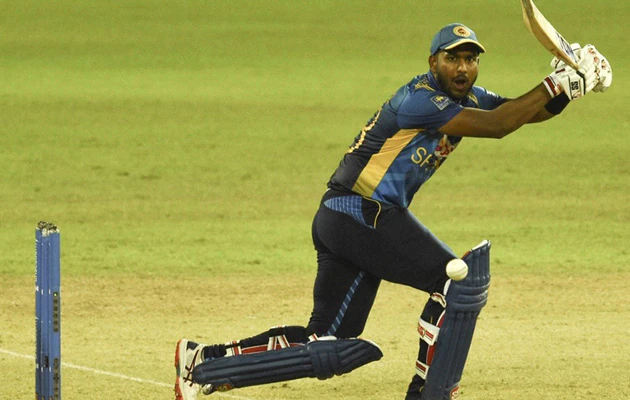

We will build a cricket player recommendation system that will suggest a list of batsmen for the team based on the statistics of players that have been playing for the team in the past.

## Setup

In [23]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import networkx as nx

import warnings
warnings.filterwarnings('ignore')

In [4]:
NUMBER_OF_SEASONS = 9
NUM_RECOMMENDATION = 15

## Data loading

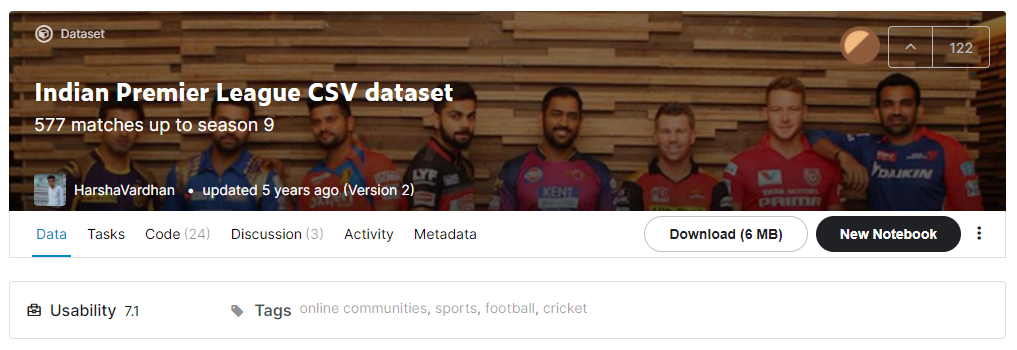

In [ ]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d harsha547/indian-premier-league-csv-dataset

In [ ]:
!unzip indian-premier-league-csv-dataset.zip

In [5]:
def read_data():
  '''
  Function to read all the CSV files
  '''
  folder_path = '/content/'
  ball_by_ball = pd.read_csv(folder_path + 'Ball_by_Ball.csv')
  match = pd.read_csv(folder_path + 'Match.csv')
  player = pd.read_csv(folder_path + 'Player.csv')
  player_match = pd.read_csv(folder_path + 'Player_Match.csv')
  return ball_by_ball, match, player, player_match

In [6]:
ball_by_ball, match, player, player_match = read_data()

In [7]:
ball_by_ball.head()

,Match_Id,Innings_Id,Over_Id,Ball_Id,Team_Batting_Id,Team_Bowling_Id,Striker_Id,Striker_Batting_Position,Non_Striker_Id,Bowler_Id,Batsman_Scored,Extra_Type,Extra_Runs,Player_dissimal_Id,Dissimal_Type,Fielder_Id
0,335987,1,1,1,1,2,1,1,2,14,0,legbyes,1,,,
1,335987,1,1,2,1,2,2,2,1,14,0,,,,,
2,335987,1,1,3,1,2,2,2,1,14,0,wides,1,,,
3,335987,1,1,4,1,2,2,2,1,14,0,,,,,
4,335987,1,1,5,1,2,2,2,1,14,0,,,,,


In [8]:
match.head()

,Match_Id,Match_Date,Team_Name_Id,Opponent_Team_Id,Season_Id,Venue_Name,Toss_Winner_Id,Toss_Decision,IS_Superover,IS_Result,Is_DuckWorthLewis,Win_Type,Won_By,Match_Winner_Id,Man_Of_The_Match_Id,First_Umpire_Id,Second_Umpire_Id,City_Name,Host_Country
0,335987,18-Apr-08,2,1,1,M Chinnaswamy Stadium,2,field,0,1,0,by runs,140.0,1.0,2.0,470,477,Bangalore,India
1,335988,19-Apr-08,4,3,1,"Punjab Cricket Association Stadium, Mohali",3,bat,0,1,0,by runs,33.0,3.0,19.0,471,487,Chandigarh,India
2,335989,19-Apr-08,6,5,1,Feroz Shah Kotla,5,bat,0,1,0,by wickets,9.0,6.0,90.0,472,512,Delhi,India
3,335990,20-Apr-08,7,2,1,Wankhede Stadium,7,bat,0,1,0,by wickets,5.0,2.0,11.0,473,476,Mumbai,India
4,335991,20-Apr-08,1,8,1,Eden Gardens,8,bat,0,1,0,by wickets,5.0,1.0,4.0,474,486,Kolkata,India


In [9]:
player.head()

,Player_Id,Player_Name,DOB,Batting_Hand,Bowling_Skill,Country,Is_Umpire,Unnamed: 7
0,1,SC Ganguly,8-Jul-72,Left_Hand,Right-arm medium,India,0,NaN
1,2,BB McCullum,27-Sep-81,Right_Hand,Right-arm medium,New Zealand,0,NaN
2,3,RT Ponting,19-Dec-74,Right_Hand,Right-arm medium,Australia,0,NaN
3,4,DJ Hussey,15-Jul-77,Right_Hand,Right-arm offbreak,Australia,0,NaN
4,5,Mohammad Hafeez,17-Oct-80,Right_Hand,Right-arm offbreak,Pakistan,0,NaN


In [10]:
player_match.head()

,Match_Id,Player_Id,Team_Id,Is_Keeper,Is_Captain
0,335987,1,1,0,1
1,335987,2,1,0,0
2,335987,3,1,0,0
3,335987,4,1,0,0
4,335987,5,1,0,0


## Preprocessing

In [13]:
def season_match_association():
  '''
  Function to create a dataframe for range of Match_Id per season
  '''
  season_info = pd.DataFrame(columns = ['Season', 'Match_Id_start', 'Match_Id_end'])
  for season in range(1, NUMBER_OF_SEASONS + 1):
    match_info = match.loc[match['Season_Id'] == season]['Match_Id']
    season_info = season_info.append({
        'Season' : season,
        'Match_Id_start' : match_info.min(), 
        'Match_Id_end' : match_info.max()
    }, ignore_index=True)
  return season_info

def add_features():
  '''
  Function to add features for every season 
  that can be used to calculate Batting Statistics
  '''
  for season in range(1, NUMBER_OF_SEASONS + 1):
    player_data['Runs_Scored_Season_'+ str(season)] = 0
    player_data['Innings_Season_'+str(season)] = 0
    player_data['NotOut_Innings_Season_'+str(season)] = 0
    player_data['Balls_Faced_Season_'+str(season)] = 0
    player_data['No4_Season_'+str(season)] = 0
    player_data['No6_Season_'+str(season)] = 0

  prev_match_id = prev_innings_id = prev_striker_id = prev_non_striker_id = 0

  NUM_OF_BALLS = len(ball_by_ball)
  for i in range(NUM_OF_BALLS):
    data = ball_by_ball.loc[i]
    current_match_id = int(data['Match_Id'])
    current_innings_id = int(data['Innings_Id'])
    current_season = str(get_season_from_match_id(current_match_id))
    current_striker_id = data['Striker_Id']
    current_non_striker_id = data['Non_Striker_Id']
    player_dismissed = 0 if data['Player_dissimal_Id'] == ' ' else int(data['Player_dissimal_Id'])
    run_scored = 0 if data['Batsman_Scored'] == 'Do_nothing' or data['Batsman_Scored'] == ' ' else int(data['Batsman_Scored'])

    if run_scored == 4:
      # Striker scored a 4 
      player_data.loc[current_striker_id - 1, 'No4_Season_' + current_season] += 1

    elif run_scored == 6: 
      # Striker scored a 6 
      player_data.loc[current_striker_id - 1, 'No6_Season_' + current_season] += 1

    # Increase the runs scored and balls faced for the current striker
    player_data.loc[current_striker_id - 1, 'Runs_Scored_Season_' + current_season] += run_scored 
    player_data.loc[current_striker_id - 1, 'Balls_Faced_Season_' + current_season] += 1 

    #update innings
    if prev_match_id != current_match_id: 
      '''
      match id of the previous ball is different
      i.e current ball is of new match
      so new innings for striker and non striker both
      '''
      increment_innings(current_striker_id, current_season)
      increment_innings(current_non_striker_id, current_season)

    else: # match id is same
      if prev_innings_id != current_innings_id:
        '''
        match id of the previous ball is same
        but innings id has changed
        so new innings for striker and non striker both
        '''
        increment_innings(current_striker_id, current_season)
        increment_innings(current_non_striker_id, current_season)

      else:
        if current_striker_id != prev_striker_id and current_striker_id != prev_non_striker_id:
          '''
          current striker was not the striker or non striker
          on the previous ball
          so new innings for striker
          '''
          increment_innings(current_striker_id, current_season)

        if current_non_striker_id != prev_striker_id and current_non_striker_id != prev_non_striker_id:
          '''
          current non striker was not the striker or non striker
          on the previous ball
          so new innings for non striker
          '''
          increment_innings(current_non_striker_id, current_season)

    if player_dismissed != 0: 
      '''
      If player was dismissed here, 
      decrement the not out innings for that player
      '''
      player_data.loc[player_dismissed - 1, 'NotOut_Innings_Season_' + str(current_season)] -= 1

    # Update the prev_match_id, prev_innings_id, prev_striker_id and prev_non_striker_id
    prev_match_id = current_match_id
    prev_innings_id = current_innings_id
    prev_striker_id = current_striker_id
    prev_non_striker_id = current_non_striker_id

def get_season_from_match_id(match_id):
  '''
  Function to return the season according to match id
  '''
  season = season_info.loc[(season_info['Match_Id_start'] <= match_id) & 
                           (season_info['Match_Id_end'] >= match_id)] ['Season']
  # Return the integer value of the season else return -1 if season is not found   
  return season.item() if not season.empty else -1

def increment_innings(player_id, season):
  '''
  Function to increment innings for the player 
  '''
  player_data.loc[player_id - 1, 'Innings_Season_' + season] += 1
  player_data.loc[player_id - 1, 'NotOut_Innings_Season_' + season] += 1

In [14]:
player_data = player.drop(["Is_Umpire", "Unnamed: 7"], axis = 1)
season_info = season_match_association()
add_features()

In [20]:
def compute_statistics():
  '''
  Function to compute batsmen statistics like BA, BSR and BRPI
  '''
  player_data['DOB_Convert'] = pd.to_datetime(player_data['DOB'])
  player_metrics = player_data[player_data.columns[:5]]
  player_metrics['Age'] = 2021 - player_data['DOB_Convert'].dt.year
  player_metrics['Age'].fillna(player_metrics['Age'].median(), inplace=True)
  # Adjust age calculation where year is ambiguous
  player_metrics['Age'] = np.where(player_metrics['Age'] < 0, 1000 - player_metrics['Age'], player_metrics['Age'])
  X = []
  NUM_OF_PLAYERS = len(player_data)
  for i in range(NUM_OF_PLAYERS):
    data = player_data.loc[i]  
    player_metrics.loc[i, 'Domestic'] = 1 if data['Country'] == 'India' else 0
    age = player_metrics.loc[i, 'Age']
    if age < 41: # only calculate metrics for eligible players
      batting_avg_list = []
      batting_sr_list = []
      brpi_list = []
      season_count = 0
      for j in range(1, NUMBER_OF_SEASONS + 1):
        runs_scored = int(data['Runs_Scored_Season_'+str(j)])
        innings_played = int(data['Innings_Season_'+str(j)])
        innings_not_out = int(data['NotOut_Innings_Season_'+str(j)])
        balls_faced = int(data['Balls_Faced_Season_'+str(j)])
        num_fours = int(data['No4_Season_'+str(j)])
        num_sixes = int(data['No6_Season_'+str(j)])
        if innings_played > 0:
          season_count += 1 
          batting_strike_rate = 0 if balls_faced == 0 else runs_scored * 100/ balls_faced
          brpi = 0 if innings_played == 0 else (4 * num_fours   + 6 * num_sixes) / innings_played
          try:
            batting_avg = runs_scored / (innings_played - innings_not_out)
          except ArithmeticError:
            batting_avg = batting_strike_rate
          batting_avg_list.append(batting_avg)
          batting_sr_list.append(batting_strike_rate)
          brpi_list.append(brpi)
      player_metrics.loc[i, 'Batting_Average'] = sum(batting_avg_list)/float(season_count) if season_count > 0 else 0.0
      player_metrics.loc[i, 'Batting_Strike_Rate'] = sum(batting_sr_list)/float(season_count) if season_count > 0 else 0.0
      player_metrics.loc[i, 'BRPI'] = sum(brpi_list)/float(season_count) if season_count > 0 else 0.0
      X.append([player_metrics.loc[i, 'Batting_Average'], player_metrics.loc[i, 'Batting_Strike_Rate'], player_metrics.loc[i, 'BRPI'], player_metrics.loc[i, 'Age'],player_metrics.loc[i, 'Domestic']])
    elif age >= 41:
      player_metrics = player_metrics.drop([i], axis = 0)
    
  player_metrics = player_metrics.drop(["DOB","Bowling_Skill"], axis = 1)
  player_metrics = player_metrics.reset_index().drop(["index"], axis = 1)
  return player_metrics, X

In [ ]:
player_metrics, X = compute_statistics()

In [24]:
player_metrics.head()

,Player_Id,Player_Name,Batting_Hand,Age,Domestic,Batting_Average,Batting_Strike_Rate,BRPI
0,2,BB McCullum,Right_Hand,40.0,0.0,58.253205,123.834150,17.239845
1,8,V Kohli,Right_Hand,33.0,1.0,50.371820,122.888128,17.001377
2,10,CL White,Right_Hand,38.0,0.0,50.087112,121.784400,9.969231
3,14,P Kumar,Right_Hand,35.0,1.0,19.212037,90.668952,2.481481
4,17,PA Patel,Left_Hand,36.0,1.0,33.258524,108.623924,11.143929


## Model fitting and Inference

In [26]:
def fetch_existing_players():
  '''
  Function to fetch players of current season for a particular team
  This has been programmed to fetch the players for Mumbai Indians only
  The team code for MI is 7
  '''
  # Fetch all matches in season
  matches_in_season = list(match.loc[match['Season_Id'] == 9]["Match_Id"])
  # Fetch all players who played in the season
  all_players = player_match.loc[player_match['Match_Id'].isin(matches_in_season)]
  # Filter players by team
  players = list(set(all_players.loc[all_players['Team_Id'] == 7]["Player_Id"]))
  return players

def sort_by_strike_rate(player_name):
  '''
  Custom sorting key to sort by strike rate
  '''
  return list(player_metrics.loc[player_metrics['Player_Name'] == player_name]['Batting_Strike_Rate'])[0]

In [27]:
X = np.array(X)
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X)
distances, indices = nbrs.kneighbors(X)
nbrs.kneighbors_graph(X).toarray()

current_players = fetch_existing_players()

recommendations = set()
for current_p_id in current_players:
  current_player = player_metrics.loc[player_metrics['Player_Id'] == current_p_id]
  if current_player.empty:
    continue
  player_index = list(current_player.index)[0]
  neighbors = indices[player_index]
  for recomm in neighbors:
    recommendations.add(list(player_metrics.iloc[[recomm]]['Player_Name'])[0])
  
sorted_recommendations = sorted(recommendations, key = sort_by_strike_rate, reverse = True)
result = pd.DataFrame(columns = player_metrics.columns)
for player in sorted_recommendations[:NUM_RECOMMENDATION]:
  details = player_metrics.loc[player_metrics['Player_Name'] == player]
  result = result.append(details, ignore_index=True)
print("-"*35,"Batsmen Recommendation for Team","-"*35,"\n")
result.head(NUM_RECOMMENDATION)

----------------------------------- Batsmen Recommendation for Team ----------------------------------- 



,Player_Id,Player_Name,Batting_Hand,Age,Domestic,Batting_Average,Batting_Strike_Rate,BRPI
0,413,KH Pandya,Left_Hand,30.0,1.0,39.500000,186.614173,18.444444
1,402,SN Khan,Right_Hand,24.0,1.0,30.375000,183.534946,10.250000
2,403,MJ McClenaghan,Left_Hand,35.0,0.0,12.166667,182.246377,4.600000
3,358,LJ Wright,Right_Hand,36.0,0.0,26.500000,168.253968,13.666667
4,381,Shivam Sharma,Right_Hand,28.0,1.0,5.000000,166.666667,2.000000
5,416,KJ Abbott,Right_Hand,34.0,0.0,13.000000,162.500000,2.000000
6,398,J Suchith,Left_Hand,27.0,1.0,48.000000,145.454545,4.666667
7,325,A Ashish Reddy,Right_Hand,30.0,1.0,51.541667,142.729469,7.216667
8,221,KA Pollard,Right_Hand,34.0,0.0,46.147891,140.388113,12.963275
9,110,AB de Villiers,Right_Hand,37.0,0.0,51.890073,139.230622,15.928663


## Graph visualization

In [28]:
adj_mat = nbrs.kneighbors_graph(X).toarray()
adj_mat

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

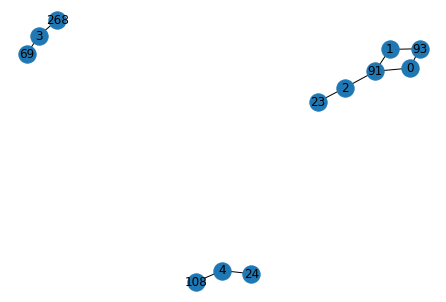

In [29]:
adj_mat = adj_mat[:5]
rows, cols = np.where(adj_mat == 1)
edges = zip(rows.tolist(), cols.tolist())
gr = nx.Graph()
gr.add_edges_from(edges)
nx.draw(gr, node_size=300, with_labels=True)
plt.show()